<a href="https://colab.research.google.com/github/vubanc/AWS_DeployedCLVPredictor/blob/main/AWS_DeployedCLVPredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Wrangling

This notebook covers the data exploration, cleaning, preprocessing and feature engineering steps of the project. The prepared ad

## Importing Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [3]:
%pwd

'/home/ec2-user/SageMaker/AWS_DeployedCLVPredictor'

In [4]:
df = pd.read_excel("Raw Dataset/UK Online Retail.xlsx")

In [5]:
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")
df.head(2)

Number of rows: 541909
Number of columns: 8


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Exploratory Data Analysis

#### Checking data types

In [6]:
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

#### Checking null values

In [7]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

#### Descriptive statistics

In [8]:
df[["Quantity", "UnitPrice"]].describe(percentiles=[0.003, 0.25, 0.5, 0.75, 0.997])

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
0.3%,-22.000000,0.000000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
99.7%,240.000000,39.950000
max,80995.000000,38970.000000


#### Distribution

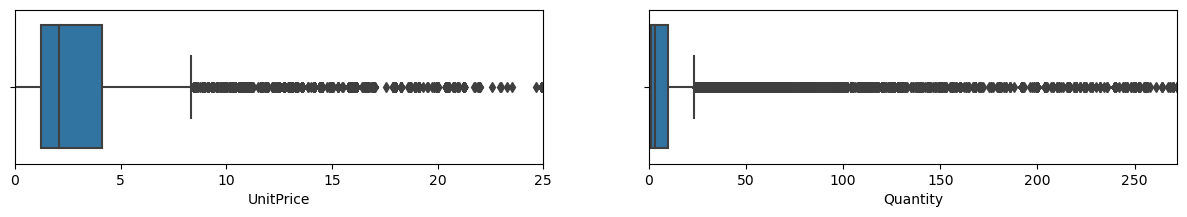

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(15, 2))

sns.boxplot(x=df["UnitPrice"].astype(float), ax=axs[0])
sns.boxplot(x=df["Quantity"].astype(float), ax=axs[1])

axs[0].set_xlim(left=0, right=25) # right limit set to 99.7 percentile value
axs[1].set_xlim(left=0, right=272) # right limit set to 99.7 percentile value

plt.show()

#### Number of purchases by month

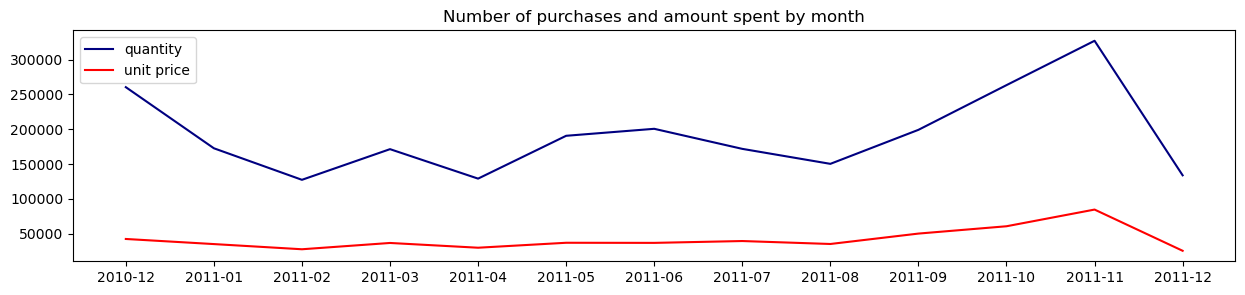

In [10]:
df_price = df.groupby(df.InvoiceDate.dt.strftime("%Y-%m"), as_index=True)["UnitPrice"].sum()
df_quantity = df.groupby(df.InvoiceDate.dt.strftime("%Y-%m"), as_index=True)["InvoiceNo"].count()


plt.figure(figsize=(15,3))
plt.title("Number of purchases and amount spent by month")
plt.plot(df_price, color='navy')
plt.plot(df_quantity, color='red')
plt.legend(['quantity', 'unit price'])

plt.show()

#### Top 5 frequent purchasing countries

In [11]:
df_quantity = df.groupby("Country", as_index=False)["InvoiceNo"].count()
df_quantity.sort_values(by="InvoiceNo", ascending=False, inplace=True)
df_quantity.head()

,Country,InvoiceNo
36,United Kingdom,495478
14,Germany,9495
13,France,8557
10,EIRE,8196
31,Spain,2533


## Data Preprocessing and Feature Engineering

#### Dropping observations with unknown customers

In [12]:
obs_before = df.shape[0]
df.dropna(subset=["CustomerID"], inplace=True)
print(f"Observations dropped: {obs_before-df.shape[0]}")
print(f"Observations remaining: {df.shape[0]}")

Observations dropped: 135080
Observations remaining: 406829


#### Removing observations with negative quantity

In [13]:
obs_before = df.shape[0]
df = df[df.Quantity > 0]
print(f"Observations dropped: {obs_before-df.shape[0]}")
print(f"Observations remaining: {df.shape[0]}")

Observations dropped: 8905
Observations remaining: 397924


#### Separating training and prediction periods

In [14]:
df = df[df.InvoiceDate.dt.year == 2011]
df1 = df[df.InvoiceDate.dt.month <= 6]
df2 = df[df.InvoiceDate.dt.month > 6]
df2 = df2[df2.CustomerID.isin(df1.CustomerID)]

print(f"Total Customers: {len(df2.CustomerID.unique())}")

Total Customers: 1871


#### Creating the recency, frequency and monetary value features

In [15]:
# Creating the recency feature
df1_CustomerRecency = df1.groupby("CustomerID", as_index=False)["InvoiceDate"].max()
df1_CustomerRecency["Recency"] = (df1.InvoiceDate.max() - df1_CustomerRecency.InvoiceDate).dt.days
df1_CustomerRecency.drop("InvoiceDate", axis=1, inplace=True)
df1 = pd.merge(df1, df1_CustomerRecency, how="inner", on="CustomerID")

In [16]:
# Creating the frequency feature
df1_CustomerFreq = df1.groupby("CustomerID", as_index=False)["InvoiceNo"].count()
df1_CustomerFreq.rename(columns={"InvoiceNo": "Frequency"}, inplace=True)
df1 = pd.merge(df1, df1_CustomerFreq, how="inner", on="CustomerID")

In [17]:
# Creating the monetary value feature
df1["MonetaryValue"] = df1.Quantity * df1.UnitPrice
df2["MonetaryValue"] = df2.Quantity * df2.UnitPrice

#### Creating the input dataset

In [18]:
df1.reset_index(drop=True, inplace=True)
df1.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Recency,Frequency,MonetaryValue
0,539993,22386,JUMBO BAG PINK POLKADOT,10,2011-01-04 10:00:00,1.95,13313.0,United Kingdom,53,31,19.5
1,539993,21499,BLUE POLKADOT WRAP,25,2011-01-04 10:00:00,0.42,13313.0,United Kingdom,53,31,10.5


In [19]:
df2.reset_index(drop=True, inplace=True)
df2.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,MonetaryValue
0,558638,84836,ZINC METAL HEART DECORATION,12,2011-07-01 08:16:00,1.25,16317.0,United Kingdom,15.0
1,558638,71459,HANGING JAM JAR T-LIGHT HOLDER,24,2011-07-01 08:16:00,0.85,16317.0,United Kingdom,20.4


In [20]:
df1 = df1.groupby("CustomerID", as_index=False)["MonetaryValue"].sum()
df2 = df2.groupby("CustomerID", as_index=False)["MonetaryValue"].sum()

df_input = pd.merge(df1, df1_CustomerRecency, how="inner", on="CustomerID")
df_input = pd.merge(df_input, df1_CustomerFreq, how="inner", on="CustomerID")
df_input = pd.merge(df_input, df2, how="inner", on="CustomerID")

df_input = df_input[["CustomerID", "Recency", "Frequency", "MonetaryValue_x", "MonetaryValue_y"]]
df_input["CustomerID"] = df_input.CustomerID.astype(int)
df_input.head(2)

,CustomerID,Recency,Frequency,MonetaryValue_x,MonetaryValue_y
0,12347,21,71,1494.16,2104.05
1,12348,86,11,594.44,310.00


#### Treating Outliers in the input dataset with KNN imputer

Number of outliers in Recency: 92
Number of outliers in Frequency: 165
Number of outliers in monetary value (training period): 144
Number of outliers in monetary value (prediction period): 248


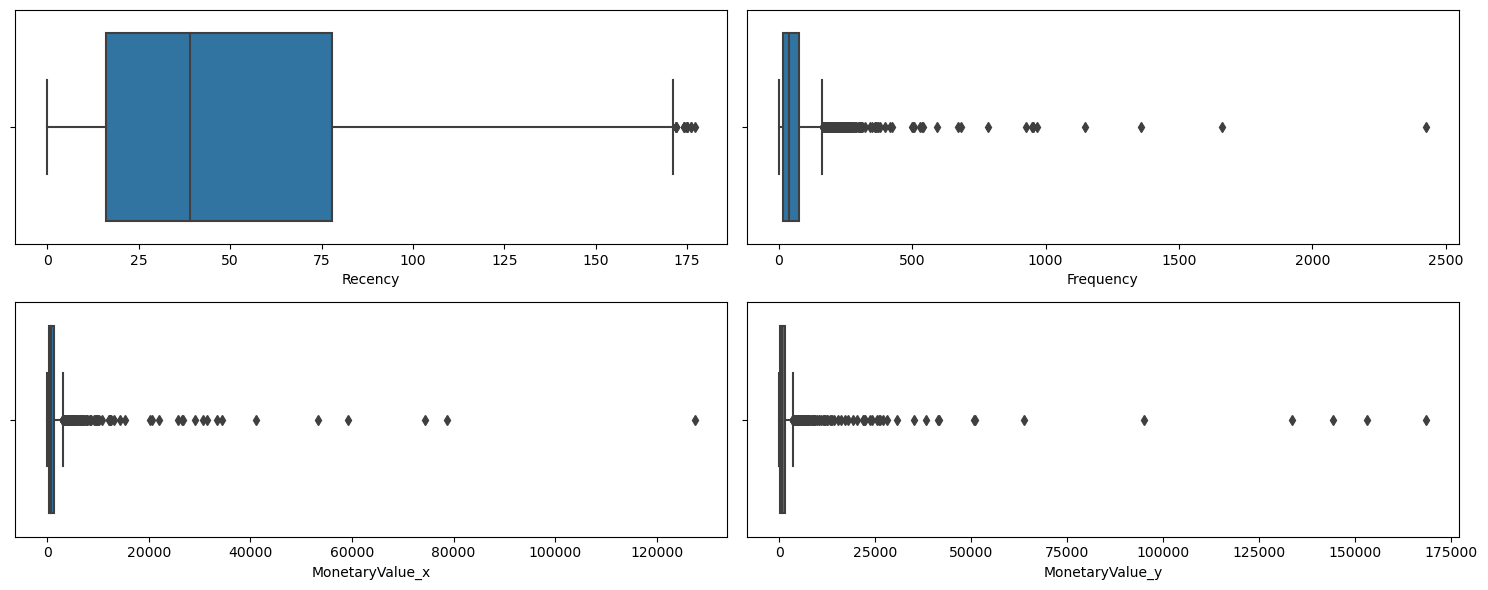

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(15, 6))

sns.boxplot(x=df_input["Recency"], ax=axs[0,0])
sns.boxplot(x=df_input["Frequency"], ax=axs[0,1])
sns.boxplot(x=df_input["MonetaryValue_x"], ax=axs[1,0])
sns.boxplot(x=df_input["MonetaryValue_y"], ax=axs[1,1])

q1, q3 = df_input.Recency.quantile(q=0.25), df_input.Recency.quantile(q=0.75)
iqr = q3-q1
recency_outliers = df_input[(df_input.Recency < df_input.Recency.mean()-1.5*iqr)|(df_input.Recency > df_input.Recency.mean()+1.5*iqr)]

q1, q3 = df_input.Frequency.quantile(q=0.25), df_input.Frequency.quantile(q=0.75)
iqr = q3-q1
frequency_outliers = df_input[(df_input.Frequency < df_input.Frequency.mean()-1.5*iqr)|(df_input.Frequency > df_input.Frequency.mean()+1.5*iqr)]

q1, q3 = df_input.MonetaryValue_x.quantile(q=0.25), df_input.MonetaryValue_x.quantile(q=0.75)
iqr = q3-q1
monetaryvalx_outliers = df_input[(df_input.MonetaryValue_x < df_input.MonetaryValue_x.mean()-1.5*iqr)|(df_input.MonetaryValue_x > df_input.MonetaryValue_x.mean()+1.5*iqr)]

q1, q3 = df_input.MonetaryValue_y.quantile(q=0.25), df_input.MonetaryValue_y.quantile(q=0.75)
iqr = q3-q1
monetaryvaly_outliers = df_input[(df_input.MonetaryValue_y < df_input.MonetaryValue_y.mean()-1.5*iqr)|(df_input.MonetaryValue_y > df_input.MonetaryValue_y.mean()+1.5*iqr)]

print(f"Number of outliers in Recency: {recency_outliers.shape[0]}")
print(f"Number of outliers in Frequency: {frequency_outliers.shape[0]}")
print(f"Number of outliers in monetary value (training period): {monetaryvalx_outliers.shape[0]}")
print(f"Number of outliers in monetary value (prediction period): {monetaryvaly_outliers.shape[0]}")

plt.tight_layout()

In [22]:
from sklearn.impute import KNNImputer

df_imputed = df_input

df_imputed.loc[df_imputed.Recency.isin(recency_outliers.Recency), "Recency"] = np.nan
df_imputed.loc[df_imputed.Frequency.isin(frequency_outliers.Frequency), "Frequency"] = np.nan
df_imputed.loc[df_imputed.MonetaryValue_x.isin(monetaryvalx_outliers.MonetaryValue_x), "MonetaryValue_x"] = np.nan
df_imputed.loc[df_imputed.MonetaryValue_y.isin(monetaryvaly_outliers.MonetaryValue_y), "MonetaryValue_y"] = np.nan

knn_imputer = KNNImputer(n_neighbors = 5)
df_input = pd.DataFrame(knn_imputer.fit_transform(df_imputed))
df_input.columns = ["CustomerID", "Recency", "Frequency", "MonetaryValue_x", "MonetaryValue_y"]

In [23]:
df_input.head(2)

,CustomerID,Recency,Frequency,MonetaryValue_x,MonetaryValue_y
0,12347.0,21.0,71.0,1494.16,2104.05
1,12348.0,86.0,11.0,594.44,310.00


In [26]:
df_input.to_csv("df_input.csv")

## Initiating Sagemaker Session and Uploading Datasets

In [24]:
import sagemaker
import boto3
import botocore

config = botocore.config.Config()
sm = boto3.client(service_name="sagemaker", config=config)
sess = sagemaker.Session(sagemaker_client=sm)

bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = sess.boto_region_name

In [27]:
s3_uri = sess.upload_data(bucket=bucket, key_prefix="data/input", path = "df_input.csv")
s3_uri

's3://sagemaker-us-east-2-397738742408/data/input/df_input.csv'

In [28]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="top" href="https://s3.console.aws.amazon.com/s3/home?region={}#">Amazon S3 buckets</a></b>'.format(region)))